In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy 

import textwrap

import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..
try:
    import graphviz
except ModuleNotFoundError as e:
    import pip
    pip.main(["install","graphviz"])
    import graphviz

from typing import Union

root_path = root_path = os.path.realpath('../../../..')
# print(root_path)
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "causaltune"))

from sklearn.model_selection import train_test_split
from causaltune import CausalTune
from causaltune.data_utils import CausalityDataset
from causaltune.datasets import generate_synthetic_data

# Import linear synthetic data creation
from causaltune.datasets import generate_linear_synthetic_data

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# set a few params
metrics = [
    #"frobenius_norm",
    #"prob_erupt",
    "policy_risk",
    #"codec",
    #"energy_distance", 
    #"psw_energy_distance"
    ]
    
n_samples = 1000
test_size = 0.33 # equal train,val,test
#time_budget = 21600
components_time_budget = 30

estimator_list = [
             #"Dummy",
             "SparseLinearDML",
             "ForestDRLearner",
             "TransformedOutcome",
             "CausalForestDML",
             ".LinearDML",
             "DomainAdaptationLearner",
             #"SLearner",
             "XLearner",
             #"TLearner",
             #"Ortho"        
    ] 

n_runs = 1
out_dir = ""
##### !!!!!!!!!!!!!!!!!!!! CHANGE FILE NAME !!!!!!!!!!!!!!!!!!!!!!!!!!
filename_out = "testing_policy_risk_30" 
##### !!!!!!!!!!!!!!!!!!!! CHANGE FILE NAME !!!!!!!!!!!!!!!!!!!!!!!!!!

# 1. Dataset Generation

In [3]:
# Create empty dictionary
data_sets = {}

### 1.1 Non-linear Data
Unkown Confounders (RCT), Known Confoudners (Observational), IV

In [4]:
# cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=False, noisy_outcomes=True)
# cd_non_linear.preprocess_dataset()
# data_sets['rct_non-linear'] = cd_non_linear

In [5]:
# cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=True, noisy_outcomes=True)
# cd_non_linear.preprocess_dataset()
# data_sets['known_confounders_non-linear'] = cd_non_linear

In [6]:
#cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=True, add_instrument=True)
#cd_non_linear.preprocess_dataset()
#data_sets['IV_non-linear'] = cd_non_linear
#cd_linear.data.head(5)

### 1.2 Linear Data
Unkown Confounders (RCT), Known Confoudners (Observational), IV

In [7]:
cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=False, noisy_outcomes=True)
cd_linear.preprocess_dataset()
data_sets['Unknown_Confounders_linear'] = cd_linear

In [8]:
#cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=True, noisy_outcomes=True)
#cd_linear.preprocess_dataset()
#data_sets['Known_Confounders_linear'] = cd_linear

In [9]:
#cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=True, add_instrument=True)
#cd_linear.preprocess_dataset()
#data_sets['IV_linear'] = cd_linear
#cd_linear.data.head(5)

# 2. Model Fitting

In [10]:
import time

run_times = {}

start_time = time.time()

for dataset_name, cd in data_sets.items():
    print("----------------- DATA SET: ",dataset_name)
    
    for i_run in range(1,n_runs+1):
        
        cd_i = copy.deepcopy(cd)
        train_df, test_df = train_test_split(cd_i.data, test_size=test_size)
        test_df = test_df.reset_index(drop=True)
        cd_i.data = train_df
        
        for metric in metrics:

            print("___________________________________________________________________________")
            print("EVALUATING: ", metric)
    
            start_time_metric = time.time()
            
            ct = CausalTune(
                metric=metric,
                metrics_to_report = [metric],
                verbose=1,
                components_verbose=1,
                components_time_budget=components_time_budget,
                estimator_list=estimator_list,
                store_all_estimators=True,
            )

            ct.fit(
                data=cd_i,
                treatment="treatment",
                outcome="outcome",
            )

            # compute relevant scores (skip newdummy)
            datasets = {"train": ct.train_df, "validation": ct.test_df, "test": test_df}
            # get scores on train,val,test for each trial, 
            # sort trials by validation set performance
            # assign trials to estimators
            estimator_scores = {est: [] for est in ct.scores.keys() if "NewDummy" not in est}
            for trial in ct.results.trials:
                # estimator name:
                estimator_name = trial.last_result["estimator_name"]
                if  trial.last_result["estimator"]:
                    estimator = trial.last_result["estimator"]
                    scores = {}
                    for ds_name, df in datasets.items():
                        scores[ds_name] = {}
                        # make scores
                        est_scores = ct.scorer.make_scores(
                            estimator,
                            df,
                            metrics_to_report=ct.metrics_to_report,
                        )

                        # add cate:
                        scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
                        # add ground truth for convenience
                        scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
                        scores[ds_name][metric] = est_scores[metric]
                    estimator_scores[estimator_name].append(scores)
                    #print("estimator_scores: ", estimator_scores)


            # sort trials by validation performance
            for k in estimator_scores.keys():
                estimator_scores[k] = sorted(
                    estimator_scores[k],
                    key=lambda x: x["validation"][metric],
                    reverse=False if metric in ["energy_distance", "psw_energy_distance", "frobenius_norm", "policy_risk","codec"] else True,
                )

            end_time_metric = time.time()
            compute_time_metric = end_time_metric - start_time_metric
    
            print(f"COMPUTE TIME METRIC: {compute_time_metric} seconds")

            run_times[metric]=compute_time_metric

            results = {
                "best_estimator": ct.best_estimator,
                "best_config": ct.best_config,
                "best_score": ct.best_score,
                "optimised_metric": metric,
                "scores_per_estimator": estimator_scores,
                "run_time": compute_time_metric
            }

            #print("best_score: ", ct.best_score,)

            with open(f"{out_dir}{filename_out}_{metric}_run_{i_run}_{dataset_name}.pkl", "wb") as f:
                pickle.dump(results, f)
            
            print("DONE WITH METRIC...")
    
            print("___________________________________________________________________________")


end_time = time.time()
total_time = end_time - start_time
print("TOTAL RUNTIME: ",total_time)



[flaml.tune.tune: 07-27 01:20:15] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-27 01:20:15] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}


----------------- DATA SET:  Unknown_Confounders_linear
___________________________________________________________________________
EVALUATING:  policy_risk
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': True, 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercep

[flaml.tune.tune: 07-27 01:22:15] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-27 01:23:45] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}}
[flaml.tune.tune: 07-27 01:24:46] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': 1, 'mc_agg': 'mean'}}
[flaml.tune.tune: 07-27 01:25:46] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': 1, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 9.999999999999999e-05, 'max_iter': 10000, 'mc_agg': 'mean'}}
[flaml.tu

COMPUTE TIME METRIC: 541.7817060947418 seconds
DONE WITH METRIC...
___________________________________________________________________________
TOTAL RUNTIME:  541.7872221469879


non_linear_600_psw_energy_distance_run_1_rct_non-linear.pkl
non_linear_600_frobenius_norm_run_1_rct_non-linear.pkl
non_linear_600_policy_risk_run_1_rct_non-linear.pkl
non_linear_600_prob_erupt_run_1_rct_non-linear.pkl
non_linear_600_codec_run_1_rct_non-linear.pkl
non_linear_600_psw_energy_distance_run_1_known_confounders_non-linear.pkl
non_linear_600_frobenius_norm_run_1_known_confounders_non-linear.pkl
non_linear_600_policy_risk_run_1_known_confounders_non-linear.pkl
non_linear_600_prob_erupt_run_1_known_confounders_non-linear.pkl
non_linear_600_codec_run_1_known_confounders_non-linear.pkl


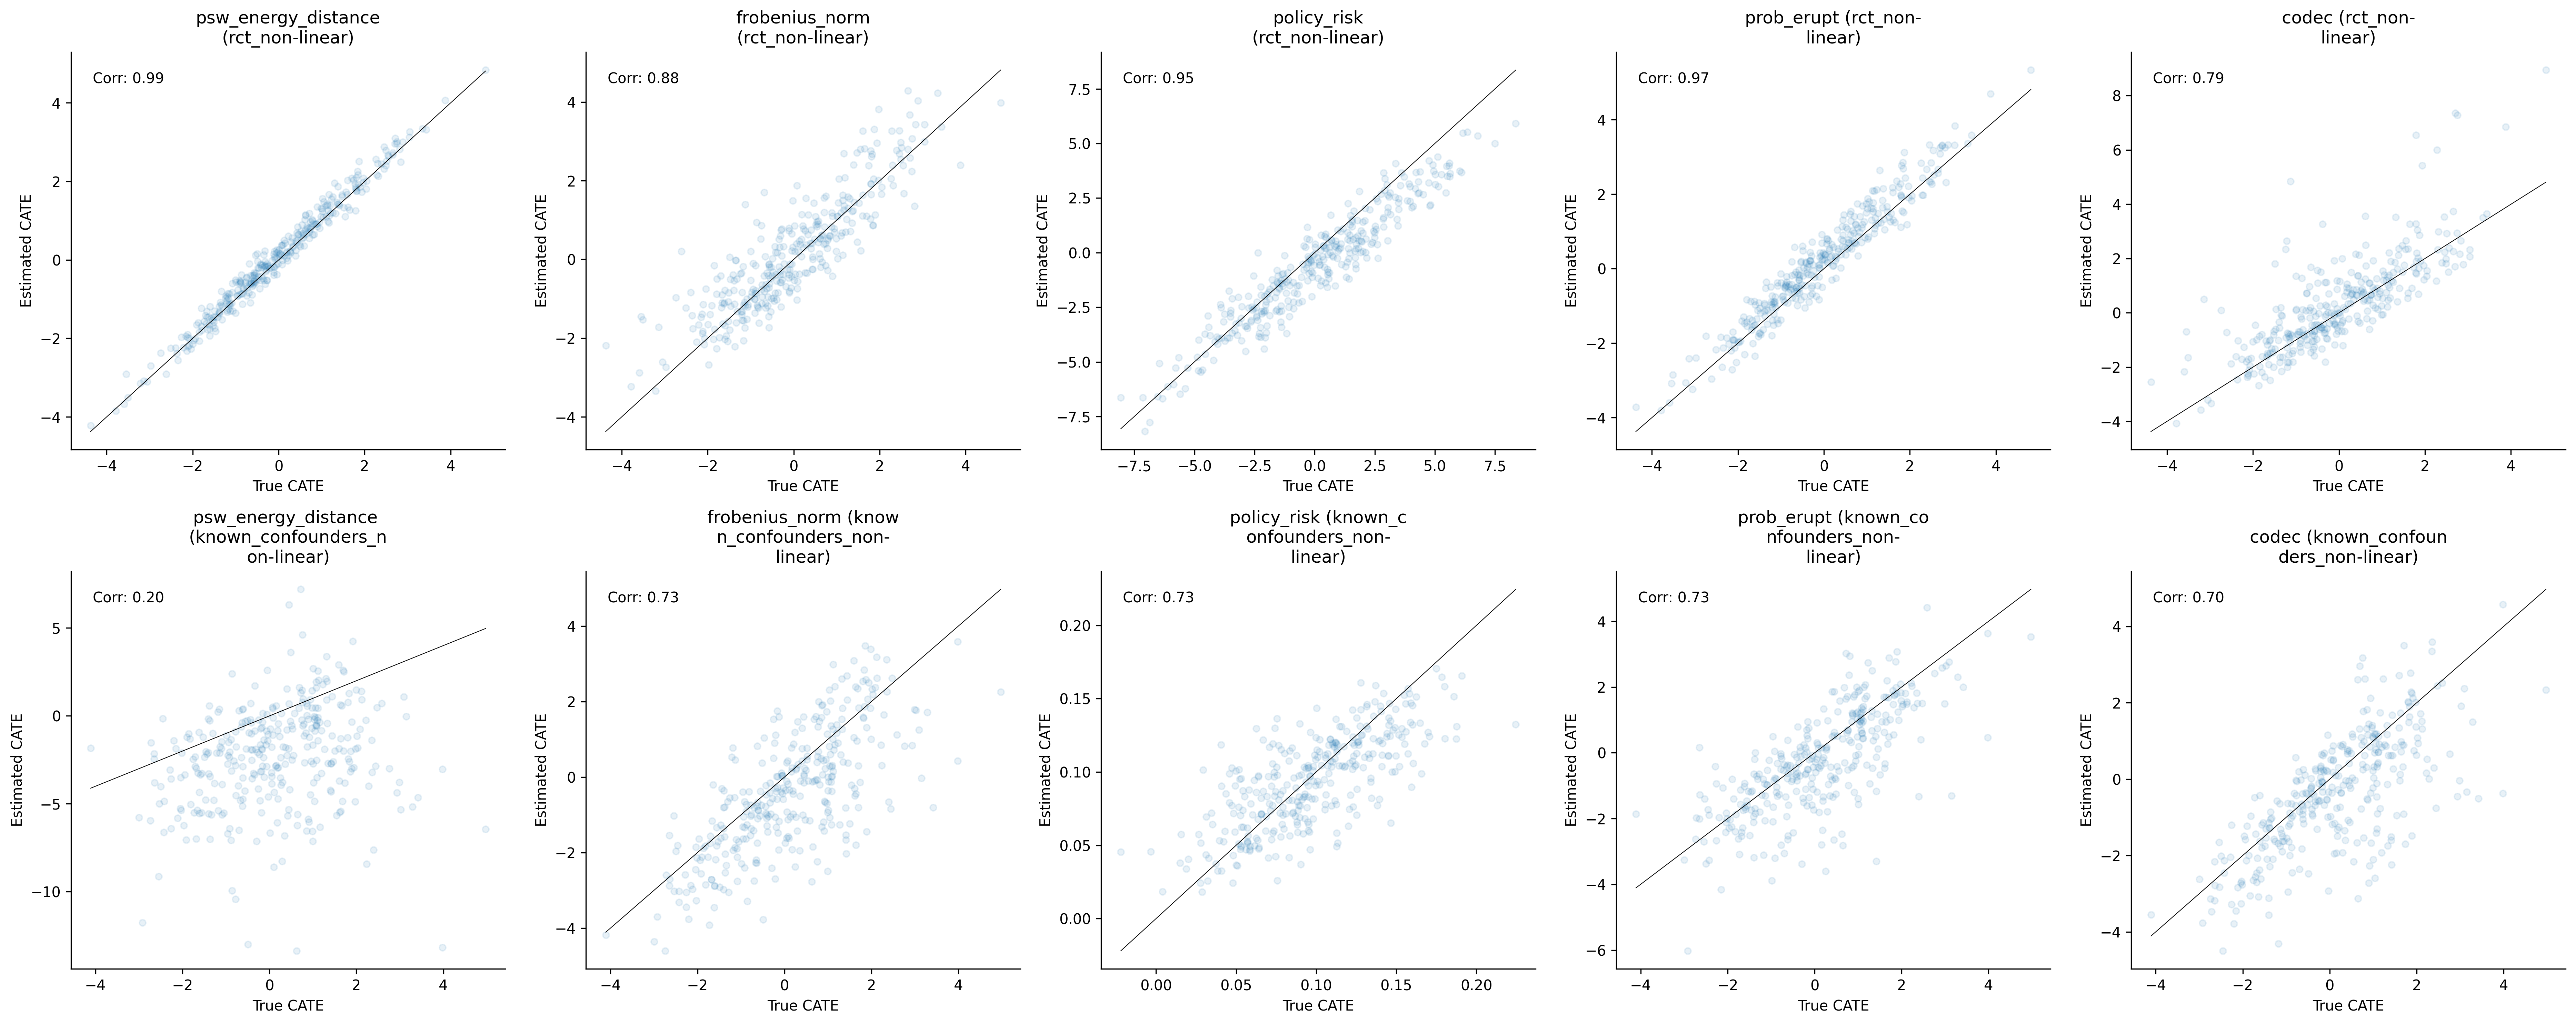

In [18]:
import matplotlib.pyplot as plt
import pickle
import textwrap
import numpy as np

# Define list of experiments and metrics
trials = ['rct_non-linear', 'known_confounders_non-linear']
metrics = ['psw_energy_distance', 'frobenius_norm', 'policy_risk', 'prob_erupt','codec']

# Create subplots
fig, axs = plt.subplots(2, 5, figsize=(25, 10), dpi=300)

# Flatten axs for easier indexing
axs = axs.flatten()

# Plot true against estimated for best estimator
for i, (trial, metric) in enumerate([(t, m) for t in trials for m in metrics]):
    ax = axs[i]
    
    # Load results
    filename = f"non_linear_600_{metric}_run_1_{trial}.pkl"
    print(filename)
    with open(filename, "rb") as f:
        results = pickle.load(f)
    
    best_estimator = results["best_estimator"]
    CATE_gt = results["scores_per_estimator"][best_estimator][0]["test"]["CATE_groundtruth"]
    CATE_est = results["scores_per_estimator"][best_estimator][0]["test"]["CATE_estimate"]
    
    # Plot
    ax.scatter(CATE_gt, CATE_est, s=20, alpha=0.1)
    ax.plot([min(CATE_gt), max(CATE_gt)], [min(CATE_gt), max(CATE_gt)], "k-", linewidth=0.5)
    
    ax.set_xlabel("True CATE")
    ax.set_ylabel("Estimated CATE")
    
    # Wrap the title text
    title_text = f"{metric}\n({trial})"
    wrapped_title = "\n".join(textwrap.wrap(title_text, width=20))
    ax.set_title(wrapped_title)
    
    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Add correlation coefficient

    cate_gt_for_cor = list(CATE_gt)
    try:
        cate_est_for_cor = CATE_est[:,0]
    except:
        cate_est_for_cor = CATE_est

    corr = np.corrcoef(cate_gt_for_cor, cate_est_for_cor)[0, 1]
    ax.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax.transAxes, 
            verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.savefig("all_metrics_comparison.pdf", format="pdf")
plt.show()

backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 
backdoor.econml.dml.SparseLinearDML: 2 intermediate runs 


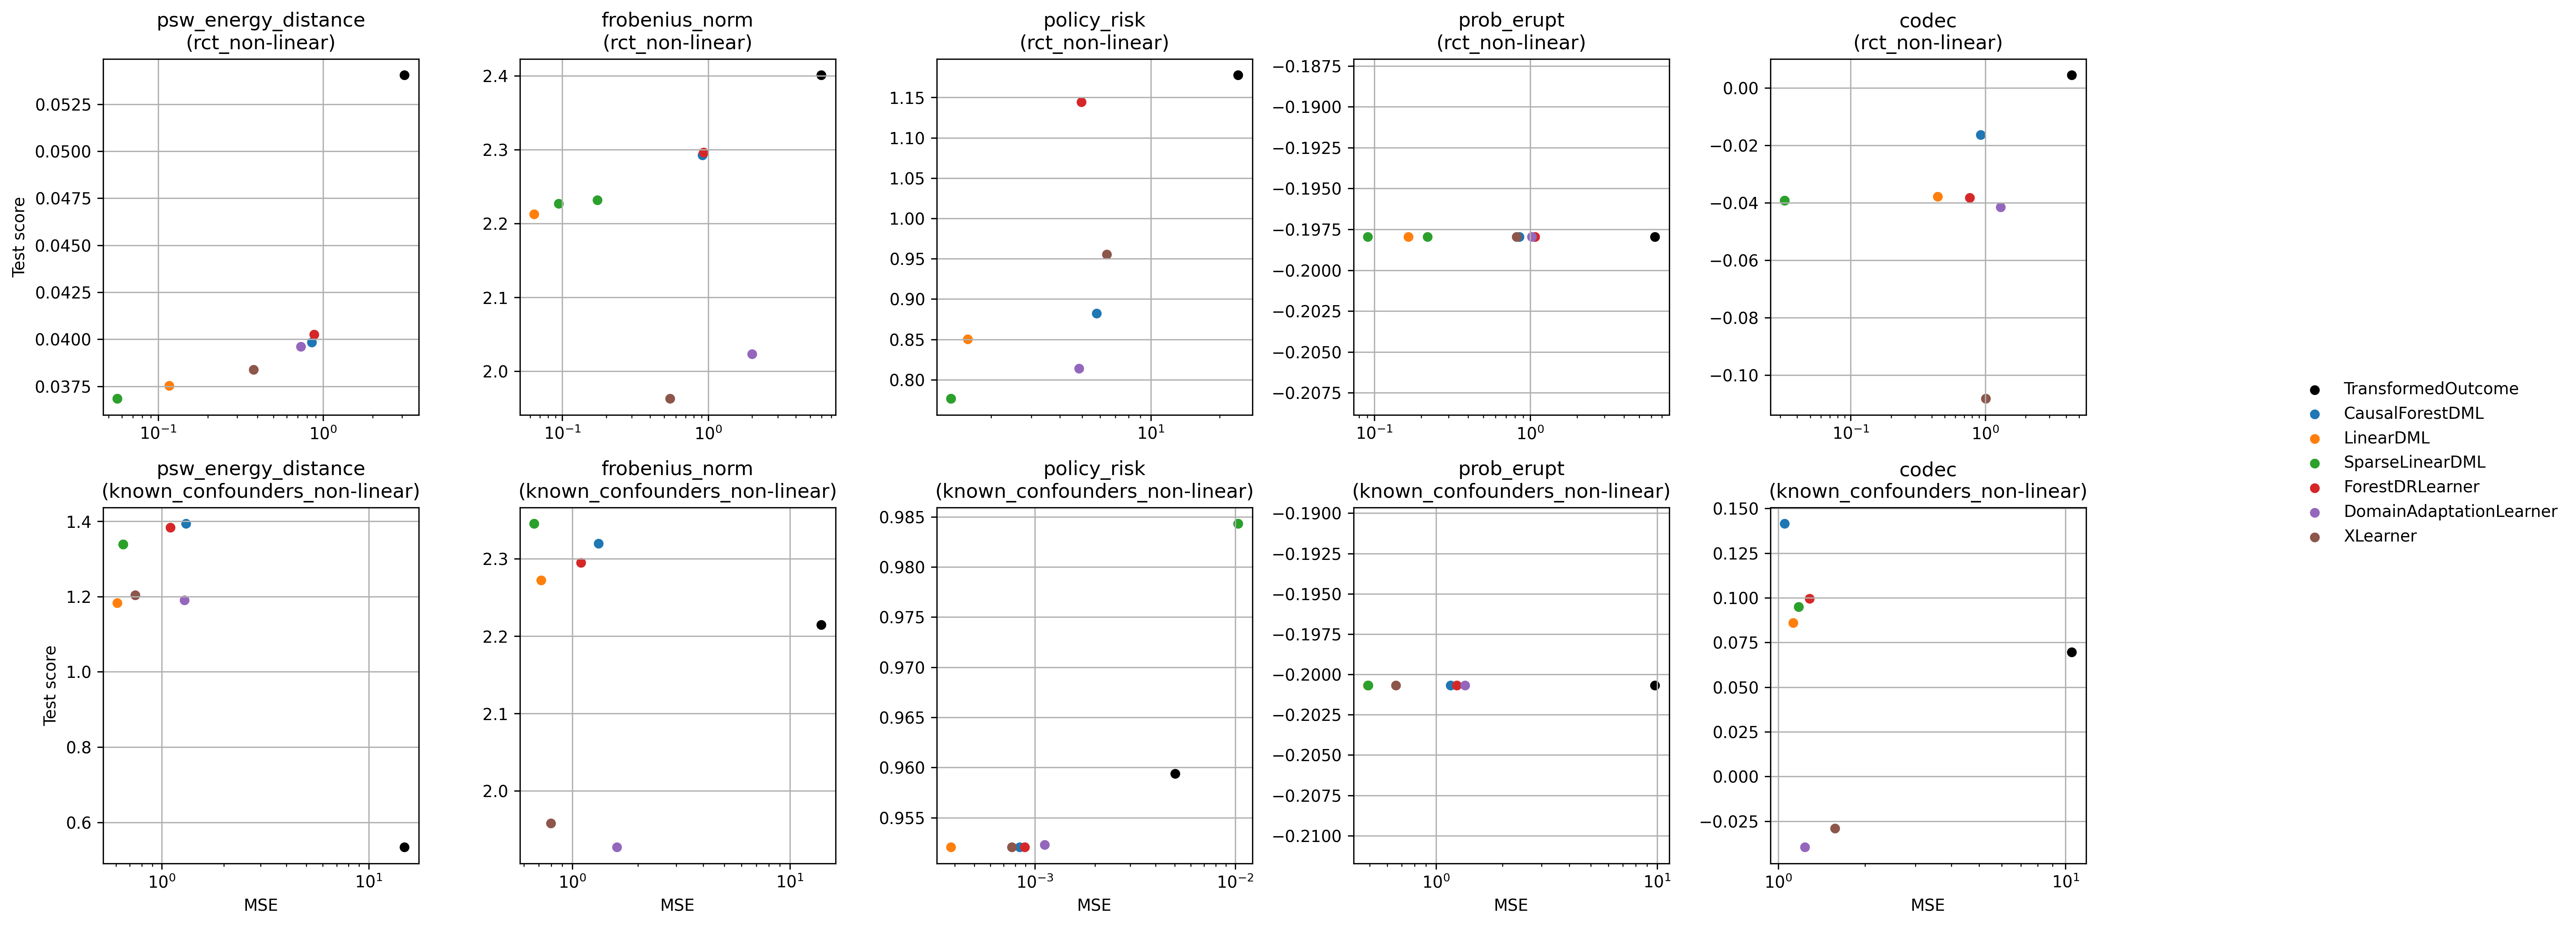

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle

import colorsys

def scale_lightness(rgb, scale_l):
    # found here https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

# Define list of experiments and metrics
trials = ['rct_non-linear', 'known_confounders_non-linear']
metrics = ['psw_energy_distance', 'frobenius_norm', 'policy_risk', 'prob_erupt','codec']

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
          list(matplotlib.colors.TABLEAU_COLORS) + [
              matplotlib.colors.CSS4_COLORS['lime'],
              matplotlib.colors.CSS4_COLORS['yellow'],
              matplotlib.colors.CSS4_COLORS['pink']
          ])

def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

fig, axs = plt.subplots(len(trials), len(metrics), figsize=(len(metrics)*4, len(trials)*4), dpi=300)

for row, trial in enumerate(trials):
    est_labels = [[] for _ in range(len(metrics))]
    for col, metric in enumerate(metrics):
        ax = axs[row, col]
        
        filename = f"non_linear_600_{metric}_run_1_{trial}.pkl"
        with open(filename, "rb") as f:
            results = pickle.load(f)
        
        for idx, (est_name, scr) in enumerate(results["scores_per_estimator"].items()):
            if "Dummy" not in est_name:
                if len(scr):
                    # Plot intermediate runs
                    if len(scr) > 1:
                        print(f"{est_name}: {len(scr)} intermediate runs ")
                        lightness = np.linspace(1, 2.8, len(scr))
                        col_rgb = matplotlib.colors.ColorConverter.to_rgb(colors[idx])
                        for i_run in range(1, len(scr)):
                            CATE_gt = scr[i_run]["test"]["CATE_groundtruth"]
                            CATE_est = scr[i_run]["test"]["CATE_estimate"]
                            CATE_gt = np.array(CATE_gt).flatten()
                            CATE_est = np.array(CATE_est).flatten()
                            mse = np.mean((CATE_gt - CATE_est)**2)
                            score = scr[i_run]["test"][metric]
                            ax.scatter(mse, score, color=scale_lightness(col_rgb, lightness[i_run-1]), s=30, linewidths=0.5, label="_nolegend_")
                    
                    # Plot best estimator
                    CATE_gt = scr[0]["test"]["CATE_groundtruth"]
                    CATE_est = scr[0]["test"]["CATE_estimate"]
                    CATE_gt = np.array(CATE_gt).flatten()
                    CATE_est = np.array(CATE_est).flatten()
                    mse = np.mean((CATE_gt - CATE_est)**2)
                    score = scr[0]["test"][metric]
                    ax.scatter(mse, score, color=colors[idx], s=30, linewidths=0.5)
                    est_labels[col].append(est_name.split(".")[-1])

        if row == len(trials) - 1:
            ax.set_xlabel("MSE")
        if col == 0:
            ax.set_ylabel("Test score")
        ax.set_title(f"{metric}\n({trial})")
        ax.set_xscale("log")
        ax.grid(True)

# Add a common legend
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(est_labels[0], loc='center right', bbox_to_anchor=(1.1, 0.5), frameon=False)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to make room for the legend
plt.savefig("all_metrics_mse_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

backdoor.econml.dml.CausalForestDML
test:  0.906503063187593
train:  0.9081369592705708
test:  0.8929884407893336
train:  0.9033928019082217
test:  0.8835778397507646
train:  0.9061184419882776
test:  0.8877380513261401
train:  0.9051152762004228
test:  0.8906520782565138
train:  0.9022873566790867
test:  0.8928810763752746
train:  0.9053648126023488
test:  0.8903909204186533
train:  0.9082730225247171


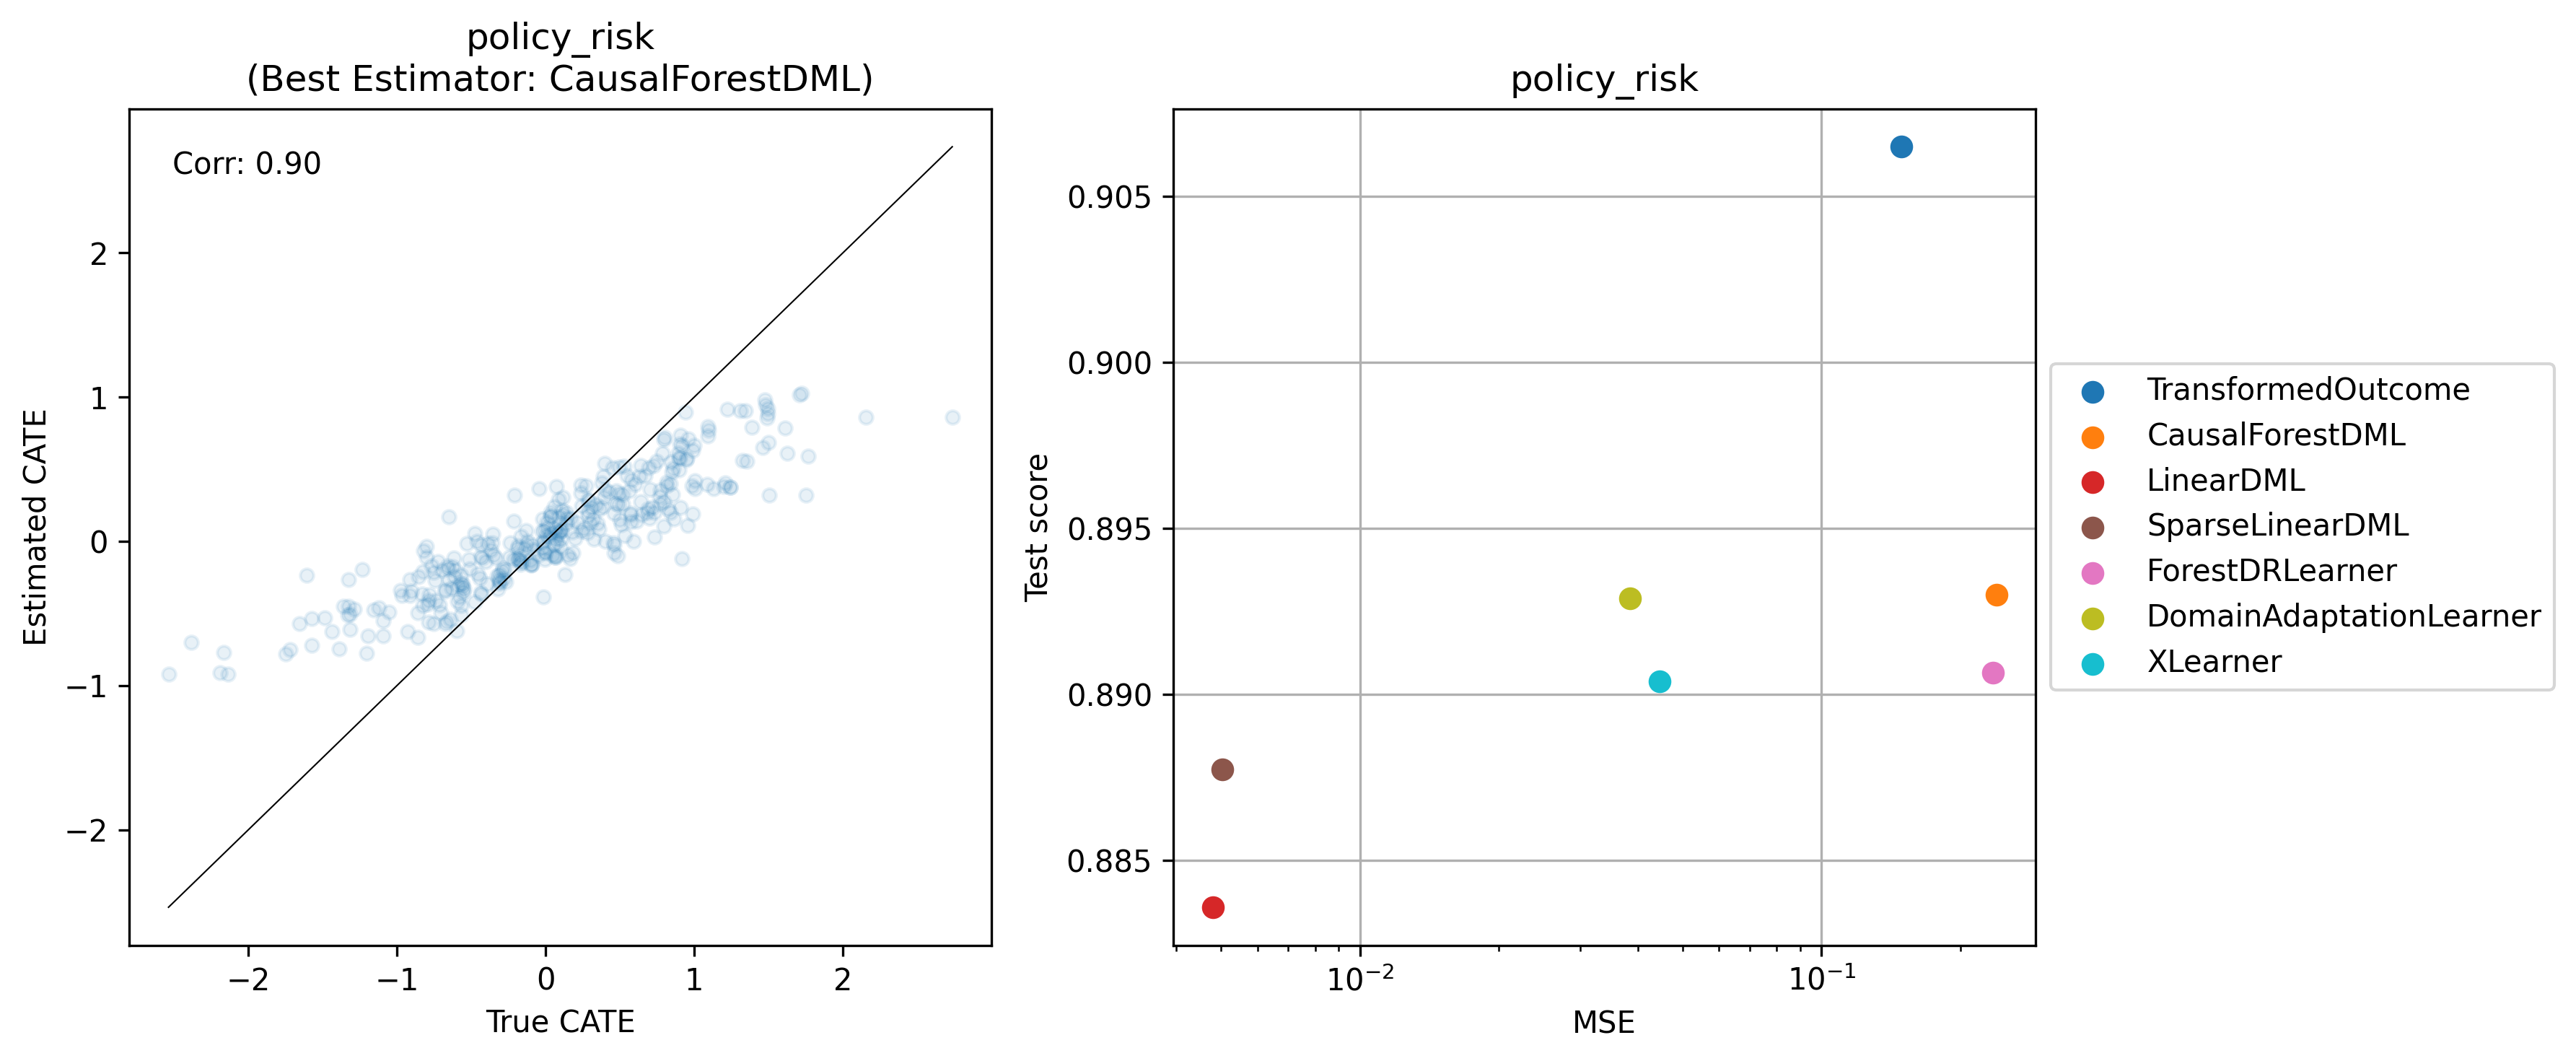

[[1.         0.33790166]
 [0.33790166 1.        ]]
[0.9081369592705708, 0.9033928019082217, 0.9061184419882776, 0.9051152762004228, 0.9022873566790867, 0.9053648126023488, 0.9082730225247171]
[0.906503063187593, 0.8929884407893336, 0.8835778397507646, 0.8877380513261401, 0.8906520782565138, 0.8928810763752746, 0.8903909204186533]


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import colorsys
%matplotlib inline

# Function to scale lightness of a color
def scale_lightness(rgba, scale_l):
    r, g, b, a = rgba
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return (*colorsys.hls_to_rgb(h, min(1, l * scale_l), s), a)

# Set up the plot
plt.figure(figsize=(12, 5), dpi=300)

# Load data
metric = 'policy_risk'
filename = f"{out_dir}{filename_out}_{metric}_run_1.pkl"
filename = 'testing_policy_risk_30_policy_risk_run_1_Unknown_Confounders_linear.pkl'
with open(filename, "rb") as f:
    results = pickle.load(f)

# Subplot 1: Estimated CATE vs True CATE
ax1 = plt.subplot(121)

best_estimator = results["best_estimator"]
print(best_estimator)
CATE_gt = results["scores_per_estimator"][best_estimator][0]["test"]["CATE_groundtruth"]
CATE_est = results["scores_per_estimator"][best_estimator][0]["test"]["CATE_estimate"]

# Ensure CATE_gt and CATE_est are 1D arrays
CATE_gt = np.array(CATE_gt).flatten()
CATE_est = np.array(CATE_est).flatten()

ax1.scatter(CATE_gt, CATE_est, s=20, alpha=0.1)
ax1.plot([min(CATE_gt), max(CATE_gt)], [min(CATE_gt), max(CATE_gt)], "k-", linewidth=0.5)

ax1.set_xlabel("True CATE")
ax1.set_ylabel("Estimated CATE")
ax1.set_title(f"{metric}\n(Best Estimator: {best_estimator.split('.')[-1]})")

# Calculate and display correlation coefficient
corr = np.corrcoef(CATE_gt, CATE_est)[0, 1]
ax1.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax1.transAxes, 
         verticalalignment='top', fontsize=10)

# Subplot 2: MSE vs Score
ax2 = plt.subplot(122)

colors = plt.cm.tab10(np.linspace(0, 1, len(results["scores_per_estimator"])))
est_labels = []

train_scores = []
test_scores = []


for (est_name, scr), col in zip(results["scores_per_estimator"].items(), colors):
    if "Dummy" not in est_name:
        if len(scr):
            # Plot intermediate runs
            if len(scr) > 1:
                lightness = np.linspace(1, 2.8, len(scr))
                for i_run in range(1, len(scr)):
                    CATE_gt = np.array(scr[i_run]["test"]["CATE_groundtruth"]).flatten()
                    CATE_est = np.array(scr[i_run]["test"]["CATE_estimate"]).flatten()
                    mse = np.mean((CATE_gt - CATE_est)**2)
                    score = scr[i_run]["test"][metric]
                    ax2.scatter(mse, score, color=scale_lightness(col, lightness[i_run-1]), 
                                s=30, linewidths=0.5, alpha=0.5)
            
            # Plot best estimator
            CATE_gt = np.array(scr[0]["test"]["CATE_groundtruth"]).flatten()
            CATE_est = np.array(scr[0]["test"]["CATE_estimate"]).flatten()
            mse = np.mean((CATE_gt - CATE_est)**2)

            score = scr[0]["test"][metric]
            test_scores.append(score)
            print("test: ", score)

            score_val = scr[0]["train"][metric]
            train_scores.append(score_val)
            print("train: ",score_val)

            ax2.scatter(mse, score, color=col, s=50, linewidths=0.5, label=est_name.split(".")[-1])
            est_labels.append(est_name.split(".")[-1])

ax2.set_xlabel("MSE")
ax2.set_ylabel("Test score")
ax2.set_title(f"{metric}")
ax2.set_xscale("log")
ax2.grid(True)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(f"{metric}_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

print(np.corrcoef(train_scores,test_scores))

print(train_scores)
print(test_scores)

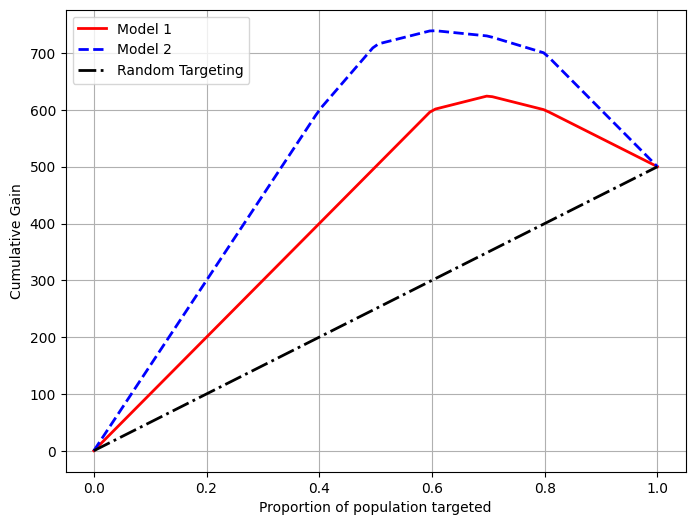

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example data
proportion_targeted = np.linspace(0, 1, 100)

# Define more points for the curves to make them smoother
key_proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
key_points_model1 = [0, 100, 200, 300, 400, 500, 600, 625, 600, 550, 500]
key_points_model2 = [0, 150, 300, 450, 600, 715, 740, 730, 700, 600, 500]

# Interpolate to create smooth curves
extra_sales_model1 = np.interp(proportion_targeted, key_proportions, key_points_model1)
extra_sales_model2 = np.interp(proportion_targeted, key_proportions, key_points_model2)

# Generate random targeting line
random_targeting = proportion_targeted * 500

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(proportion_targeted, extra_sales_model1, 'r-', label='Model 1', linewidth=2)
plt.plot(proportion_targeted, extra_sales_model2, 'b--', label='Model 2', linewidth=2)
plt.plot(proportion_targeted, random_targeting, 'k-.', label='Random Targeting', linewidth=2)

plt.xlabel('Proportion of population targeted')
plt.ylabel('Cumulative Gain')
plt.legend()
plt.grid(True)
plt.show()